## This code produces Figure 8 in the Appendix.

### Packages and settings

In [9]:
import sys
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
import torch.nn as nn

sys.path.append('../')
from utils import datasets
import utils.resnet_cond as resnet
import utils.lightning_flows as LFlows


In [2]:
# use GPUs if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device: %s'%(device))

Device: cuda


### Plots

In [4]:
# Load maps and parameters from the LH set.
home_dir   = Path("/n/netscratch/dvorkin_lab/Lab/aakhmetzhanova/evidence-estimation-Astrid/") 

field    = 'Mgas'
splits   = 15
n_params = 6
params  = np.loadtxt(home_dir / 'data/params_LH_Astrid.txt',)[:, :n_params]
minimum = np.array([0.1, 0.6, 0.25, 0.25, 0.5, 0.5])[:n_params]
maximum = np.array([0.5, 1.0, 4.00, 4.00, 2.0, 2.0])[:n_params]
params  = (params - (minimum+maximum)/2)/((maximum - minimum)/2)   # rescale parameters
params  = np.repeat(params[:, None, :], splits, axis = 1)          # reshape the parameters to match the shape of the maps 
params  = torch.tensor(params).float()

grid     = 256
BoxSize  = 25
maps     = np.load(home_dir / f'data/2D/Maps_{field}_Astrid_LH_z=0.00.npy')
maps     = maps.reshape(params.shape[0], -1, 1, grid, grid)[:, :splits]
maps     = torch.tensor(maps).float()

# Load normalization constants.
maps_LH     = np.load(home_dir / f'data/2D/Maps_{field}_Astrid_LH_z=0.00.npy')
maps_mean, maps_std = np.log10(maps_LH).mean(), np.log10(maps_LH).std()


In [6]:
# Load summarizer and parameter estimation network.
npe_k_cond = False
n_params   = 6
summary_dim = 40

save_dir   = home_dir / f'trained_models/Maps_{field}/'
checkpoint = save_dir / f'summarizer_no_smoothing_{field}_Astrid/'
checkpoint = checkpoint / 'k_conv_lr_7e-5/checkpoints/best_val_loss.ckpt'

model = LFlows.LightningFlow.load_from_checkpoint(checkpoint, device=device,
                                                  summary_dim=summary_dim, n_params=n_params,
                                                  model_name='resnet10t.c3_in1k',)
model.summarizer.eval();
model.density_estimator.eval();


In [7]:
# Compute predicted means and errors on the parameters.
params_true = []
params_pred = []
errors_pred = []
    
seed       = 1
batch_size = 100
train_frac, valid_frac, test_frac = 0.9, 0.05, 0.05
_, _, test_dset = datasets.create_datasets_maps(maps, params, 
                                                train_frac, valid_frac, test_frac,
                                                seed=seed, 
                                                rotations=False, 
                                                smoothing=False, 
                                                log_scale=True, standardize=True,
                                                maps_mean=maps_mean, maps_std=maps_std,)
dataloader  = DataLoader(test_dset, batch_size, shuffle = False,)

for maps_test, params_test, k_test in dataloader:
    with torch.no_grad():
        maps_test    = maps_test.float().to(device=device)
        params_test  = params_test.float().to(device=device)
        bs           = maps_test.shape[0]

        summaries      = model.summarizer(maps_test)
        params_samples = model.density_estimator(summaries).sample((10_000,))
        params_samples = params_samples.detach().cpu().numpy()
        
        params_samples = params_samples*(maximum[None, None, :] - minimum[None, None, :])/2 + (minimum[None, None, :]+maximum[None, None, :])/2  
            
        params_test    = params_test.detach().cpu().numpy()
        params_test    = params_test*(maximum[None, :] - minimum[None, :])/2 + (minimum[None, :]+maximum[None, :])/2  
        
            
        params_true.append(params_test)
        params_pred.append(params_samples.mean(axis=0))
        errors_pred.append(params_samples.std(axis=0))
            
params_true = np.concatenate(params_true, axis=0)
params_pred = np.concatenate(params_pred, axis=0)
errors_pred = np.concatenate(errors_pred, axis=0)


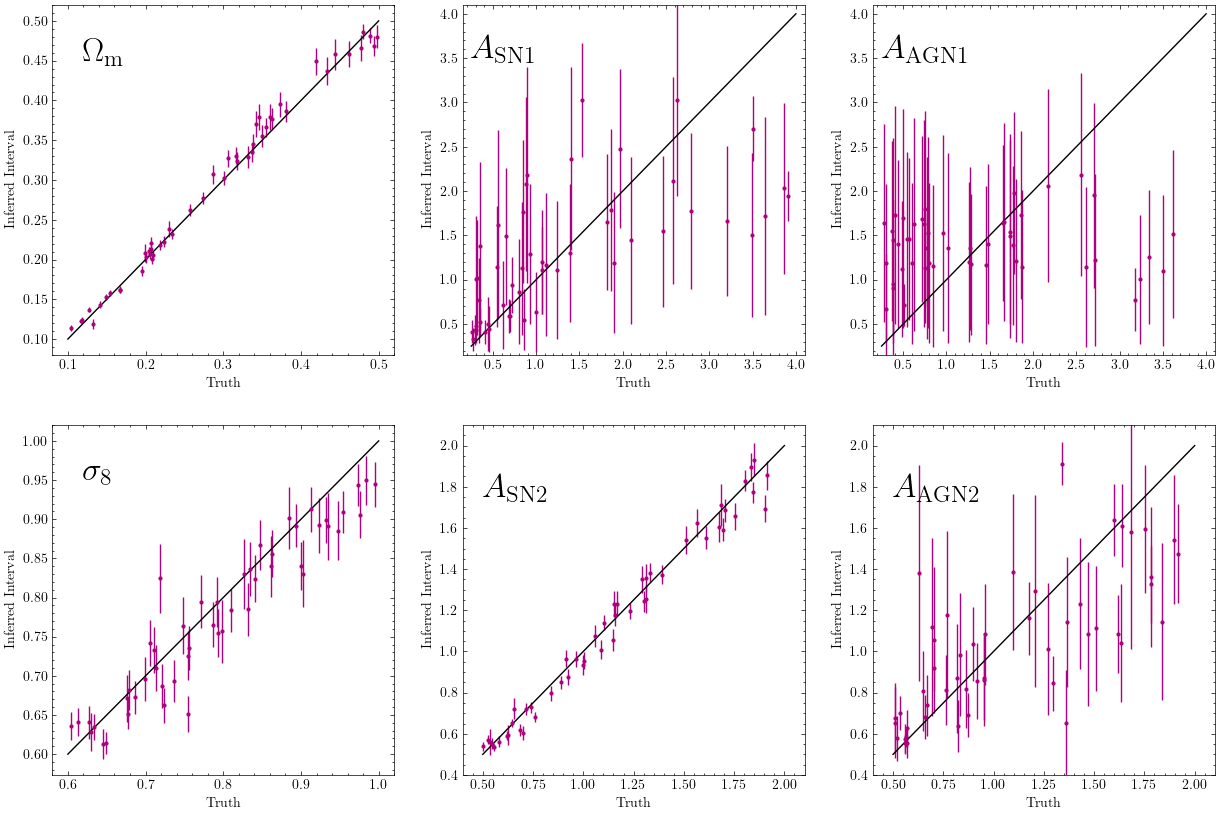

In [8]:
# Plot predicted parameters against true parameters.
# select the first map of every simulation in the test set
indexes        = np.arange(50)*splits + 2
param_fontsize = 24
color = '#ae017e' 


plt.style.use(['science'])
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs[0, 0].set_xlabel(r'${\rm Truth}$')
axs[0, 0].set_ylabel(r'${\rm Inferred \, \, Interval}$')
axs[0, 0].text(0.12, 0.45, r'$\Omega_{\rm m}$',fontsize=param_fontsize)
axs[0, 0].errorbar(params_true[indexes,0], 
                   params_pred[indexes,0], 
                   errors_pred[indexes,0], 
                   linestyle='None', lw=1, fmt='o', ms=2, elinewidth=1, capsize=0, c=color)
axs[0, 0].plot([0.1,0.5], [0.1,0.5], color='k')

axs[1, 0].set_xlabel(r'${\rm Truth}$')
axs[1, 0].set_ylabel(r'${\rm Inferred \, \, Interval}$')
axs[1, 0].text(0.62, 0.95, r'$\sigma_8$',fontsize=param_fontsize)
axs[1, 0].errorbar(params_true[indexes,1], 
                   params_pred[indexes,1], 
                   errors_pred[indexes,1], 
                   linestyle='None', lw=1, fmt='o', ms=2, elinewidth=1, capsize=0, c=color)
axs[1, 0].plot([0.6,1.0], [0.6,1.0], color='k')


axs[0, 1].set_xlabel(r'${\rm Truth}$')
axs[0, 1].set_ylabel(r'${\rm Inferred \, \, Interval}$')
axs[0, 1].text(0.25, 3.5, r'$A_{\rm SN1}$',fontsize=param_fontsize)
axs[0, 1].errorbar(params_true[indexes,2], 
                   params_pred[indexes,2], 
                   errors_pred[indexes,2], 
                   linestyle='None', lw=1, fmt='o', ms=2, elinewidth=1, capsize=0, c=color)
axs[0, 1].plot([0.25,4.0], [0.25,4.0], color='k')
axs[0, 1].set_ylim(0.15, 4.1)
axs[0, 1].set_xlim(0.15, 4.1)


axs[1, 1].set_xlabel(r'${\rm Truth}$')
axs[1, 1].set_ylabel(r'${\rm Inferred \, \, Interval}$')
axs[1, 1].text(0.5, 1.75, r'$A_{\rm SN2}$',fontsize=param_fontsize)
axs[1, 1].errorbar(params_true[indexes,4], 
                   params_pred[indexes,4], 
                   errors_pred[indexes,4],  
                   linestyle='None', lw=1, fmt='o', ms=2, elinewidth=1, capsize=0, c=color)
axs[1, 1].plot([0.5,2.0], [0.5,2.0], color='k')
axs[1, 1].set_ylim(0.4, 2.1)
axs[1, 1].set_xlim(0.4, 2.1)

axs[0, 2].set_xlabel(r'${\rm Truth}$')
axs[0, 2].set_ylabel(r'${\rm Inferred \, \, Interval}$')
axs[0, 2].text(0.25, 3.5, r'$A_{\rm AGN1}$',fontsize=param_fontsize)
axs[0, 2].errorbar(params_true[indexes,3], 
                   params_pred[indexes,3], 
                   errors_pred[indexes,3],  
                   linestyle='None', lw=1, fmt='o', ms=2, elinewidth=1, capsize=0, c=color)
axs[0, 2].plot([0.25,4.0], [0.25,4.0], color='k')
axs[0, 2].set_ylim(0.15, 4.1)
axs[0, 2].set_xlim(0.15, 4.1)

axs[1, 2].set_xlabel(r'${\rm Truth}$')
axs[1, 2].set_ylabel(r'${\rm Inferred \, \, Interval}$')
axs[1, 2].text(0.5, 1.75, r'$A_{\rm AGN2}$',fontsize=param_fontsize)
axs[1, 2].errorbar(params_true[indexes,5], 
                   params_pred[indexes,5], 
                   errors_pred[indexes,5], 
             linestyle='None', lw=1, fmt='o', ms=2, elinewidth=1, capsize=0, c=color)
axs[1, 2].plot([0.5,2.0], [0.5,2.0], color='k')
axs[1, 2].set_ylim(0.4, 2.1)
axs[1, 2].set_xlim(0.4, 2.1)


fig.savefig('plots/2_npe_constraints_{:s}_no_smoothing.pdf'.format(field))